# Modelización Responsable

En este notebook enseñamos los resultados de los cuatro pilares que explicaran el 30% de la puntuación:

- Explicabilidad 
- Transparencia
- Justicia
- Sostenibilidad ambiental

## Explicabilidad

Para  una  mejor  adopción  de  la  IA  los  modelos  deber  ser  explicables,  debemos 
evitar hablar de modelos de  caja blanca / negra. 

En el desarrollo de  todo modelo 
debe tenerse en cuenta la explicabilidad desde el diseño, un modelo explicable se 
integra en la gestión de  forma más rápida que  uno que  no lo es, incluso modelos 
no  explicables  pueden  llegar  a  no  utilizarse  nunca  aun  teniendo  una  muy  buena 
precisión.

Nuestro mejor modelo fue creado utilizando el algoritmo **Random Forest**. Creemos que este algoritmo tiene una alta capacidad de predicción como tambien de explicabilidad. Nos pareció un buen punto medio entre modelos simples como regresiones lineales y redes neuronales, donde la explicabilidad es menor.

A partir de librerias como **Shap**, podemos visualizar la explicabilidad a partir de gráficos interesantes.

### Importancia de variables

EXPLICAR COMO SE CALCULA Y CUALES SON LAS MAS IMPORTNATES

### xxx

## Transparencia

Memoria del modelo

- Instrucciones de uso 
- Tratamientos sobre los datasets de datos 
- Elección de la muestra de entrenamiento y validación 
- Argumento de la tipología del modelo a desarrollar 
- Criterios aplicados para la selección del ganador 
- Visualización y explicación de los resultados

## Justicia

La IA debe usarse de forma justa, por lo que debe de velar por la equidad y evitar 
sesgos de  cualquier tipo. En el  desarrollo de  cualquier modelo, y desde el diseño, 
debe revisarse que la muestra es lo suficientemente representativa y que no existe 
ningún sesgo (ni en los datos utilizados en el entrenamiento ni en el 
comportamiento del propio modelo).

Para esto, corroboraremos  la  suficiente  diversidad  de  la 
muestra, así como la inexistencia de sesgos.

Es de ayuda la libreria **AI Fairness** https://aif360.mybluemix.net

PARA ESTO CREO QUE PODEMOS MOSTRAR LAS DISTRIBUCIONES DE TRAIN Y TEST, PARA LAS TODAS LAS VARIABLES

Importamos librerias

In [30]:
#!pip install aif360

import aif360
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt 
import seaborn as sns

from malbecs.modeling import train as tr
from malbecs.modeling import models as mm

seed = 99

Comenzamos evaluando las distribuciones en el entrenamiento y validación. Para esto, cargamos los datasets finales y hacemos el split.

Recordar que realizamos el split en una forma temporal. Es decir, si el set de validación es 2021, el de entrenamiento serán todos los datos que sean de campañas anteriores a esta.

In [5]:
wine_data = pd.read_csv('../data/final/wine_final.csv')
eto_data = pd.read_csv('../data/final/eto_final.csv')
meteo_data = pd.read_csv('../data/final/meteo_final.csv')

In [6]:
data = tr.merge_data(
    wine_data,
    eto_data,
    meteo_data
)

In [10]:
data_train = tr.filter_camp(data.copy(), min_camp=15, max_camp=21)
data_final = tr.filter_camp(data, min_camp=22, max_camp=22)
train, test = tr.train_test_split(data_train, test_camp=21)
X, y = tr.xy_split(data_train)

cat_cols = [
    'id_finca', 
    'id_zona',
    'id_estacion', 
    'variedad',
    "modo", 
    "tipo",
    "color", 
    "prod_shift1_gt_shift2"
]
num_cols = [col for col in X.columns if col not in cat_cols]

X[cat_cols] = X[cat_cols].astype('category')

X_train, y_train = tr.xy_split(train)
X_test, y_test = tr.xy_split(test)
X_final, y_final = tr.xy_split(data_final)

train_idxs, test_idxs = tr.CampKFold.get_train_test(
    X['campaña'], from_camp=19, to_camp=21
)

cv = tr.CampKFold(train_idxs, test_idxs)

Evaluamos entrenamiento y validación para las variables mas importantes del modelo.

- El promedio de producción y superficie no presenta diferencias en ambos grupos.

In [17]:
print(f'El set de entrenamiento cuenta con {X_train.shape[0]} registros, mientras que el set de validación con {X_test.shape[0]} registros.')

El set de entrenamiento cuenta con 6334 registros, mientras que el set de validación con 1044 registros.


In [20]:
print(f'El promedio de la producción en uno y el otro es de {round(y_train.mean(),2)}kg y {round(y_test.mean(),2)}kg, respectivamente.')

El promedio de la producción en uno y el otro es de 9301.91kg y 9964.51kg, respectivamente.


In [21]:
print(f'El promedio de la superficie en uno y el otro es de {round(X_train.superficie.mean(),2)} hectarias y {round(X_test.superficie.mean(),2)} hectarias, respectivamente.')

El promedio de la superficie en uno y el otro es de 2.14 hectarias y 2.17 hectarias, respectivamente.


Tambien notamos que hay variedades de vino que tienen menores producciones y superficies, pero puede notarse una relacion entre estas dos ultimas.

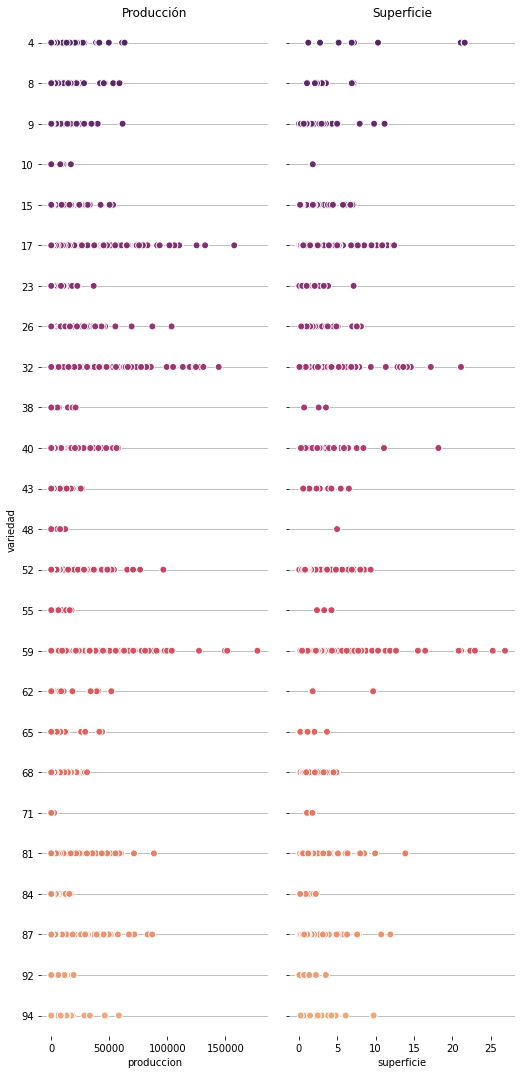

In [31]:
g = sns.PairGrid(data,
                 x_vars=['produccion','superficie'], y_vars=["variedad"],
                 height=15, aspect=.25)

g.map(sns.stripplot, size=7, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")

titles = ["Producción", "Superficie"]

for ax, title in zip(g.axes.flat, titles):

    ax.set(title=title)

    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

Ahora revisamos el bias de las predicciones.

In [25]:
%%time 
models = []
for i in range(10):
    m = mm.get_final_model()
    m.set_params(randomforestregressor__random_state=mm.seed*(1+i))
    m.fit(X, y)
    models.append(m)

preds_final = []
for model in models:
    preds_final.append(model.predict(X_final))
y_pred_final = np.mean(preds_final,0)

Wall time: 4.18 s


Podemos evaluar las predicciones del modelo según la superficie de las fincas. Esto lo podemos realizar separandolas en percentiles:

In [33]:
Q1 = X.superficie.quantile(0.25)
Q2 = X.superficie.quantile(0.5)
Q3 = X.superficie.quantile(0.75)

Q1,Q2,Q3

(0.6393, 1.3416, 2.6326750000000003)

In [42]:
bias_df = data_final.copy()
bias_df['preds'] = y_pred_final

bias_df['sup_q'] =[0 if x < Q1 else 1 if x < Q2 else 2 if x < Q3 else 3 for x in bias_df.superficie]

bias_df = bias_df[['superficie','sup_q','preds']]

Aunque no hay una relacion directa entre superficie y producción...

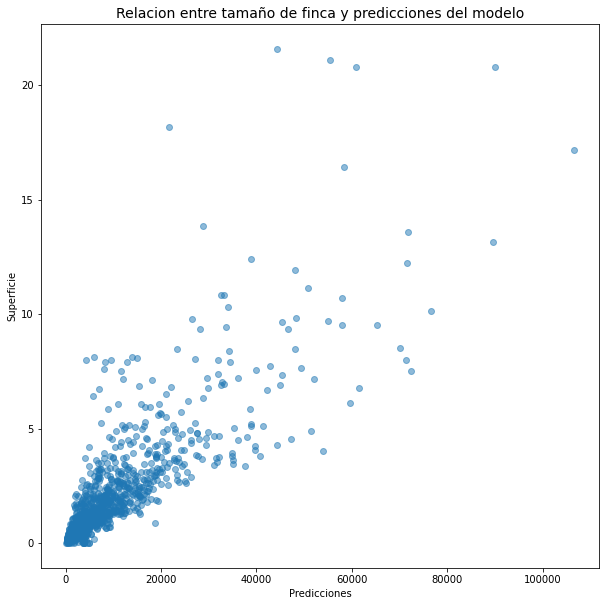

In [46]:
plt.figure(figsize=(10,10))
plt.scatter(x=bias_df.preds, y=bias_df.superficie , alpha=0.5)
plt.xlabel('Predicciones')
plt.ylabel('Superficie')
plt.title('Relacion entre tamaño de finca y predicciones del modelo', fontsize=14)
plt.show()

...si la hay entre el percentil de esta y las predicciones.

Sin embargo, no consideramos esto como un bias, ya que el tamaño de una finca es clave para conocer el potencial de producción que esta pueda tener.

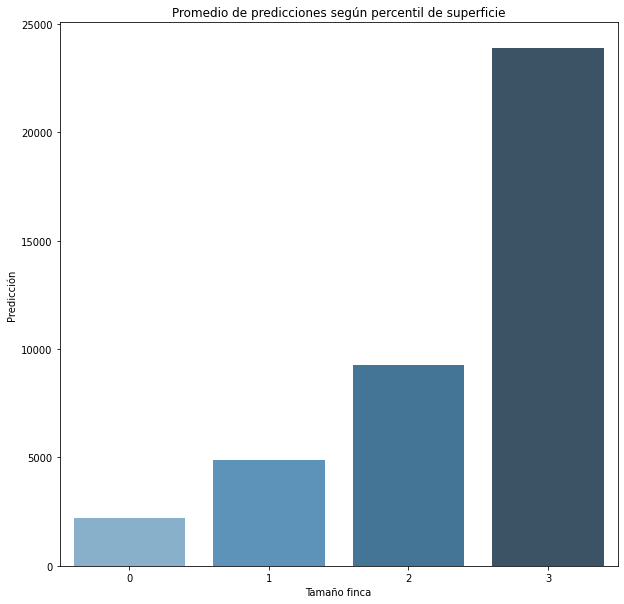

In [64]:
bias_avg = bias_df.groupby('sup_q')['preds'].agg('mean').reset_index()
plt.figure(figsize=(10,10))
sns.barplot(data=bias_avg, x='sup_q', y='preds',palette='Blues_d')
plt.xlabel('Tamaño finca')
plt.ylabel('Predicción')
plt.title('Promedio de predicciones según percentil de superficie')
plt.show()

## Sostenibilidad Ambiental

El desarrollo de los modelos de IA debe velar por la sostenibilidad y ser 
respetuosos con el medioambiente, por lo que se deberá asegurar la optimización 
computacional que garantice un menor consumo energético.

Este, comparado a otros intentos como Support Vector Machines o Redes Neuronales, resulta eficiente en terminos de sostenibilidad y optimización computacional.

Nuestro modelo, como se vio anteriormente, tardó 4.2 segundos en ejecutarse. Easto se traduce en un uso de 0.3 de la CPU.

In [28]:
import psutil
print('The CPU usage is: ', psutil.cpu_percent(4.2))

The CPU usage is:  0.3


En cuanto a memoria:

In [26]:
import psutil
 
# Getting % usage of virtual_memory ( 3rd field)
print('RAM memory % used:', psutil.virtual_memory()[2])
# Getting usage of virtual_memory in GB ( 4th field)
print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)

RAM memory % used: 55.1
RAM Used (GB): 9.288310784
